# **Pattern recognition - Final class project**

## Author: Murilo Chianfa | UEL

> Network traffic time series forecasting

# Preprocessing data from NetFlow

The NetFlow V9 data collect using Nfdump tool, so we need to preproccess them to extract just the relevant content.

In this example, i was filtered the incoming traffic from the Vlan33 of our Uplink from 2024-10-19 00:00 to 2024-10-25 23:55.

As result we've the date in timeslots by 5 minutes and the average of inbound traffic in bits per second.

- To proprocess them, u can use the extract-traffic.go module

In [128]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('rt-mk-vlan33-bps-from-19-to-25-october.csv')
df.head()

,date,bps
0,202410190000,45421984
1,202410190005,2007052
2,202410190010,7150983
3,202410190015,9679427
4,202410190020,11744915


## Seeing the shape of our database

We've 7 days collected in timeshifts of 5 minutes each, so lets extract the average bitrate for one transit uplink interface:

- 60m / 5m = 12 collections
- 12 collections * 24h = 288 collections a day
- 288 collections * 7d = 2016 collections total

In [129]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M')
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
print(df.head())

(2016, 2)
                 date       bps
0 2024-10-19 00:00:00  45421984
1 2024-10-19 00:05:00   2007052
2 2024-10-19 00:10:00   7150983
3 2024-10-19 00:15:00   9679427
4 2024-10-19 00:20:00  11744915


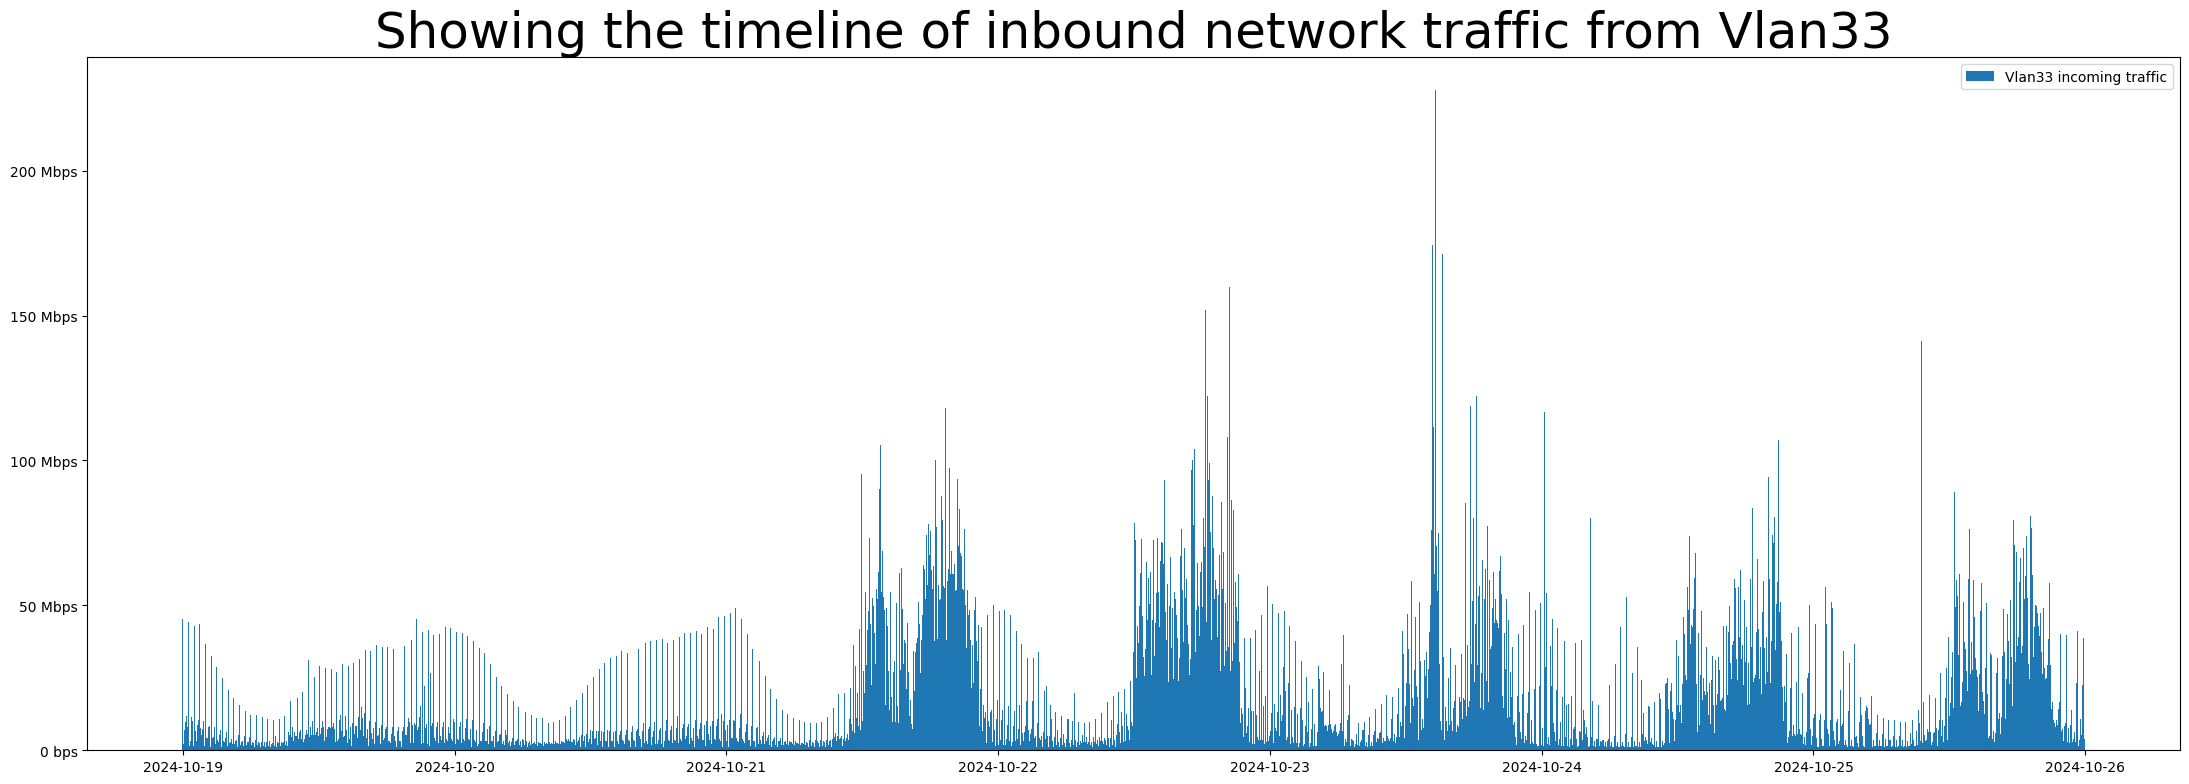

In [130]:
from matplotlib.ticker import EngFormatter
import matplotlib.pyplot as plt
import datetime

fig = plt.figure(figsize=(27, 9))
plt.title("Showing the timeline of inbound network traffic from Vlan33", fontdict={'fontsize': 36})
plt.bar(df['date'], df['bps'], width=datetime.timedelta(minutes=5), label='Vlan33 incoming traffic')
formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

Scale bits per second values

In [131]:
from sklearn.preprocessing import MinMaxScaler

bps_values = df['bps'].values.reshape(-1, 1)
bps_scaler = MinMaxScaler()
bps_scaled = bps_scaler.fit_transform(bps_values)

## Augmented Dickey-Fuller, ACF and PACF test



In [132]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(bps_scaled)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.296745
p-value: 0.000450
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


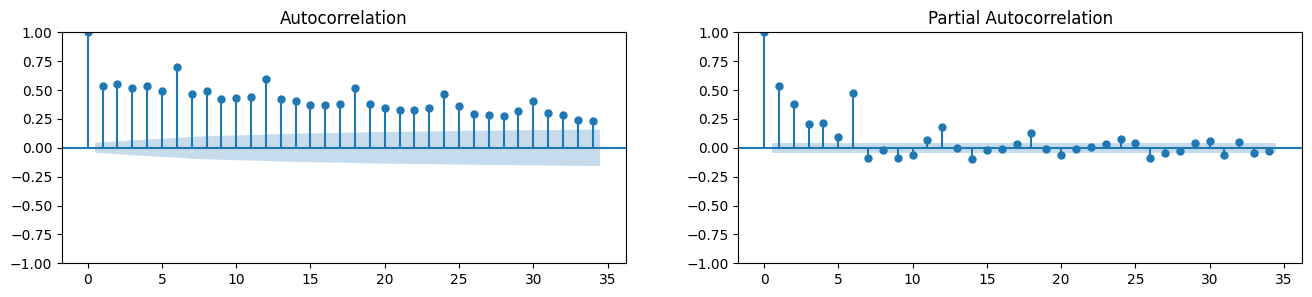

In [133]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(bps_scaled, ax=axes[0])
plot_pacf(bps_scaled, ax=axes[1])

plt.show()

## Spliting preprocessed data into train and test

In [134]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [135]:
seq_length = 10
X, y = create_sequences(bps_scaled, seq_length)

# Split the data
train_size = int(len(X) * 0.6)
valid_size = int(len(X) * 0.2)
test_size = len(X) - train_size - valid_size

# Setup datasets
X_train = X[:train_size]
y_train = y[:train_size]

X_valid = X[train_size:train_size+valid_size]
y_valid = y[train_size:train_size+valid_size]

X_test = X[train_size+valid_size:]
y_test = y[train_size+valid_size:]

# Corresponding dates (adjusted for the sequence length)
dates = df['date'].values[seq_length:]
dates_train = dates[:train_size]
dates_valid = dates[train_size:train_size+valid_size]
dates_test = dates[train_size+valid_size:]

# Reshape y to be 2D arrays
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Setting up the time series forecasting LSTM model

In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def simpleLSTM(X_train, y_train, X_valid, y_valid, epochs, neurons, num_of_future_forecasts=1):
    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]

    model = Sequential()
    model.add(LSTM(neurons, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(num_of_future_forecasts))
    model.compile(optimizer='adam', loss='mse')

    print("Training LSTM Model...")
    model.fit(X_train, y_train, epochs=epochs, verbose=1, validation_data=(X_valid, y_valid))

    # Predictions
    train_yhat = model.predict(X_train)
    valid_yhat = model.predict(X_valid)
    test_yhat = model.predict(X_test)

    return model, train_yhat, valid_yhat, test_yhat

## Training the model to forecast network traffic

In [137]:
epochs = 20
neurons = 50

model, train_yhat, valid_yhat, test_yhat = simpleLSTM(X_train, y_train, X_valid, y_valid, epochs, neurons)

Training LSTM Model...
Epoch 1/20


/root/test-uel/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0099
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0098
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0098
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0099
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0097
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0095
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0096
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0098
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0095
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0094
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0097


In [138]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Inverse transform the predictions and actual values
actual_train = bps_scaler.inverse_transform(y_train)
actual_valid = bps_scaler.inverse_transform(y_valid)
actual_test = bps_scaler.inverse_transform(y_test)

predicted_train = bps_scaler.inverse_transform(train_yhat)
predicted_valid = bps_scaler.inverse_transform(valid_yhat)
predicted_test = bps_scaler.inverse_transform(test_yhat)

# Create DataFrames
df_train = pd.DataFrame({
    'date': dates_train,
    'actual': actual_train.flatten(),
    'predicted': predicted_train.flatten(),
    'set': 'train'
})

df_valid = pd.DataFrame({
    'date': dates_valid,
    'actual': actual_valid.flatten(),
    'predicted': predicted_valid.flatten(),
    'set': 'validation'
})

df_test = pd.DataFrame({
    'date': dates_test,
    'actual': actual_test.flatten(),
    'predicted': predicted_test.flatten(),
    'set': 'test'
})

df_all = pd.concat([df_train, df_valid, df_test], axis=0)
dates_all = pd.to_datetime(df_all['date'])

## Showing the results of our predictions

In [139]:
from datetime import timedelta
base_time = pd.to_datetime([df['date'][0]], format='%Y%m%d%H%M')[0]

len_dates_train = len(dates_train)
train_line = [base_time + timedelta(minutes=5 * i) for i in range(len_dates_train)][-1]

len_dates_valid = len(dates_valid)
valid_line = [base_time + timedelta(minutes=5 * i) for i in range(len_dates_train + len_dates_valid)][-1]

len_dates_test = len(dates_test)
test_line = [base_time + timedelta(minutes=5 * i) for i in range(len_dates_train + len_dates_valid + len_dates_test)][-1]

len_all_dates = len(dates_all)

vertical_lines_positions = pd.to_datetime([
    train_line,
    valid_line
], format='%Y%m%d%H%M')

print(vertical_lines_positions)

date_ranges = [
    (base_time, train_line),
    (train_line, valid_line),
    (valid_line, '2035-10-25 23:55:55')
]

colors = ['red', 'green', 'blue']
legends = ['Train', 'Valid', 'Test']
legend_positions = [0.25, 0.665, 0.9]

DatetimeIndex(['2024-10-23 04:10:00', '2024-10-24 13:35:00'], dtype='datetime64[ns]', freq=None)


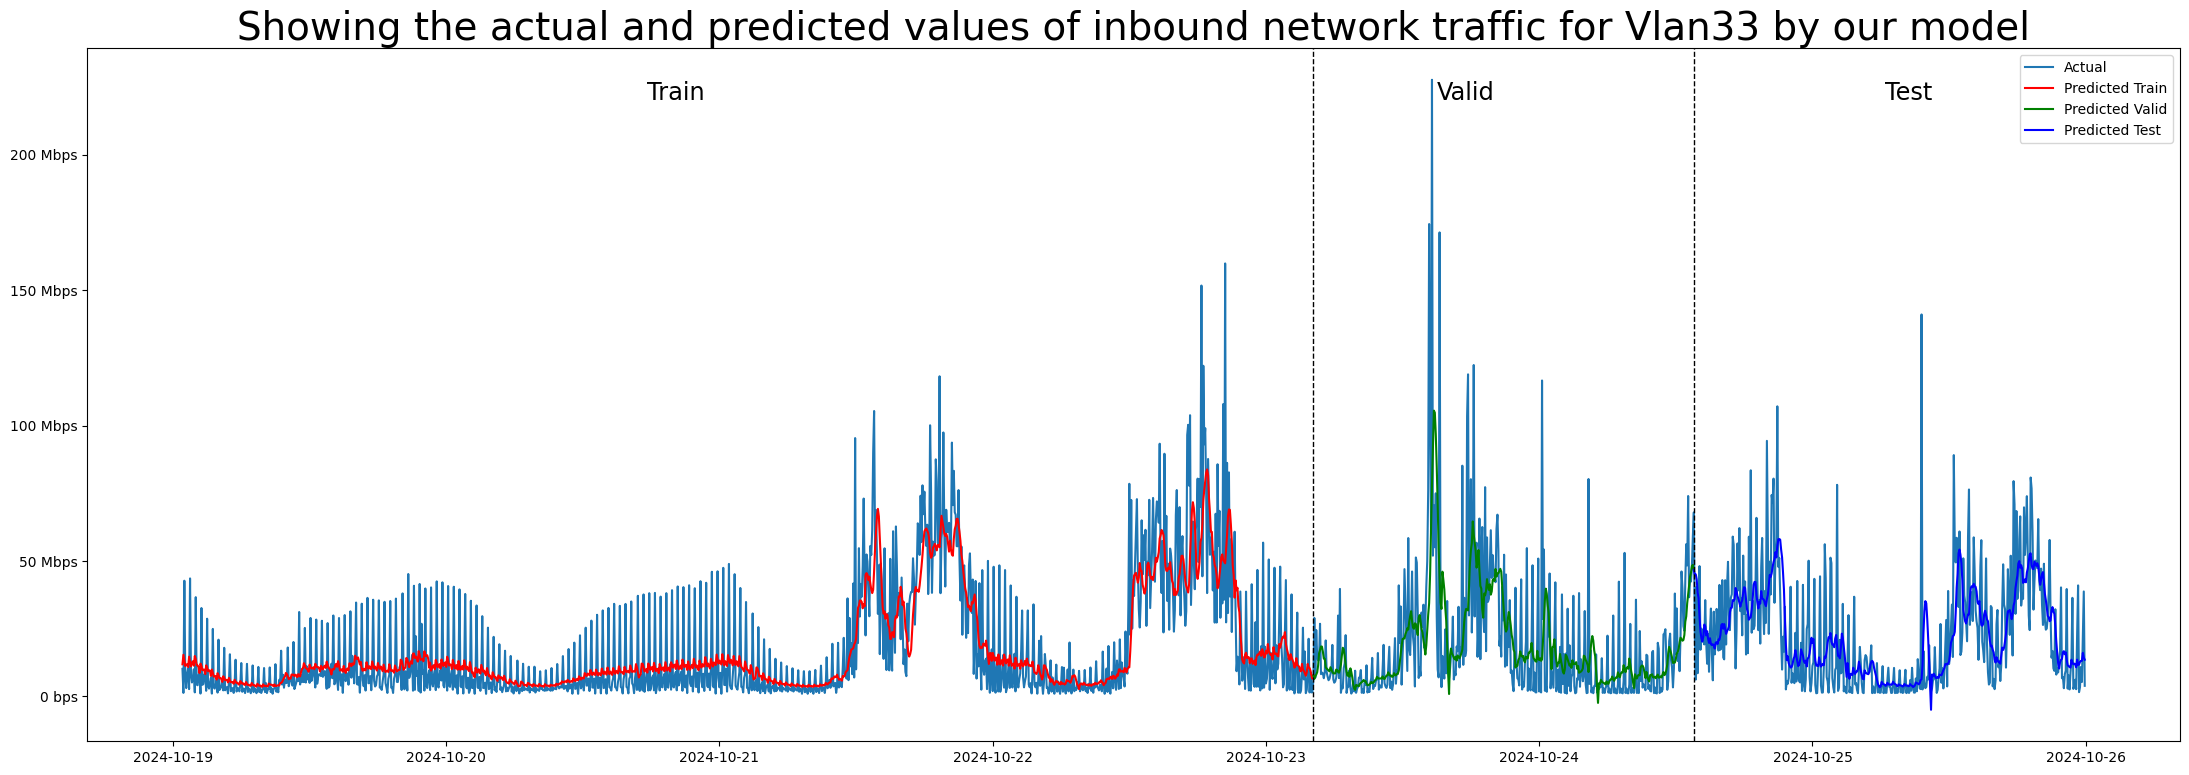

In [140]:
fig = plt.figure(figsize=(27, 9))
plt.title("Showing the actual and predicted values of inbound network traffic for Vlan33 by our model", fontdict={'fontsize': 28})

plt.plot(df_all['date'], df_all['actual'], label='Actual')


for i, ((start_date_str, end_date_str), color, legend) in enumerate(zip(date_ranges, colors, legends)):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    mask = (df_all['date'] >= start_date) & (df_all['date'] <= end_date)

    plt.plot(
        df_all.loc[mask, 'date'],
        df_all.loc[mask, 'predicted'],
        color=color, label='Predicted ' + legend
    )

for x in vertical_lines_positions:
    plt.axvline(x=x, color='k', linestyle='--', linewidth=1)

formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)

for legend, position in zip(legends, legend_positions):
  plt.text(
      pd.to_datetime([[base_time + timedelta(minutes=5 * i) for i in range(int(len_all_dates * position))][-1]], format='%Y%m%d%H%M')[0],
      0.95 * plt.ylim()[1],
      legend, verticalalignment='top', fontdict={'fontsize': 'xx-large'}
  )

plt.legend()
plt.show()

## Trying to forecast future timestamps

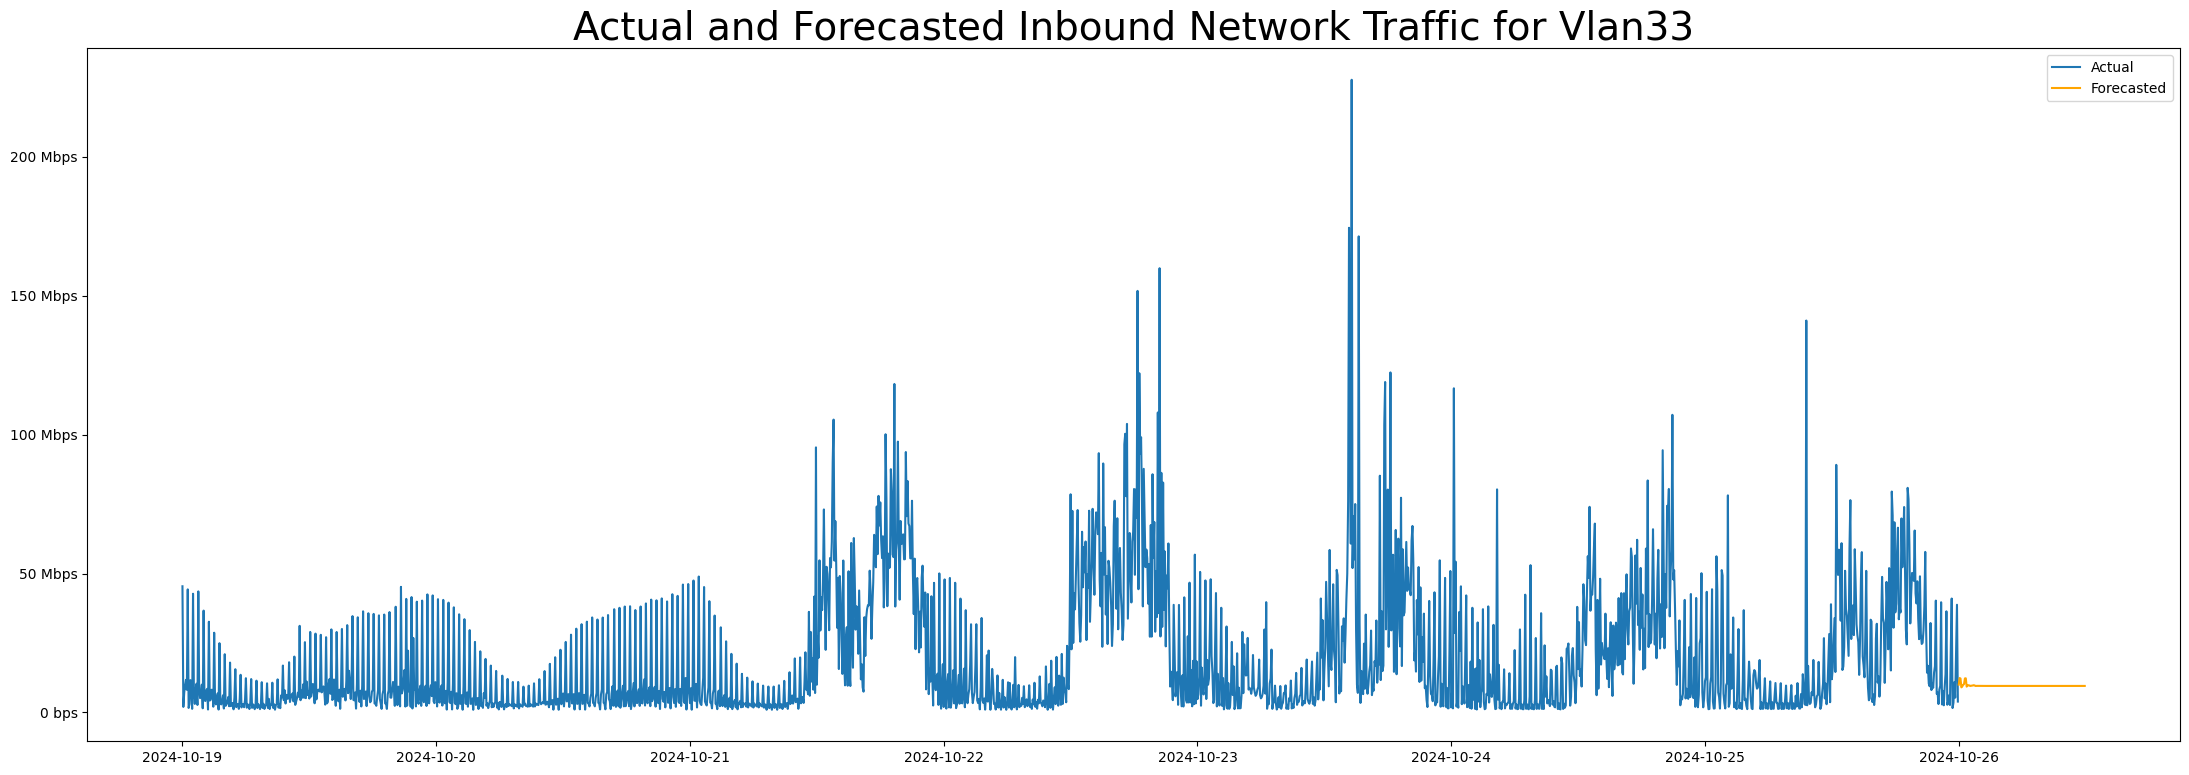

In [149]:
future_steps = 144

# Get the last sequence from the scaled data
last_sequence = bps_scaled[-seq_length:]

# Perform recursive forecasting
future_predictions_scaled = []
input_seq = last_sequence.copy()

for _ in range(future_steps):
    input_seq_reshaped = input_seq.reshape(1, seq_length, 1)
    yhat = model.predict(input_seq_reshaped, verbose=0)
    future_predictions_scaled.append(yhat[0, 0])
    input_seq = np.append(input_seq[1:], yhat[0, 0])

# Inverse transform the predictions
future_predictions = bps_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = [last_date + datetime.timedelta(minutes=5 * i) for i in range(1, future_steps + 1)]

# Create a DataFrame for future predictions
df_future = pd.DataFrame({
    'date': future_dates,
    'predicted': future_predictions.flatten()
})

# Combine historical data and future predictions
df_combined = pd.DataFrame({
    'date': pd.concat([df['date'], df_future['date']]),
    'bps': pd.concat([df['bps'], pd.Series([np.nan]*len(df_future))]),
    'predicted': pd.concat([pd.Series([np.nan]*len(df)), df_future['predicted']])
})

# Plot the results
fig = plt.figure(figsize=(27, 9))
plt.title("Actual and Forecasted Inbound Network Traffic for Vlan33", fontdict={'fontsize': 28})

plt.plot(df_combined['date'], df_combined['bps'], label='Actual')
plt.plot(df_combined['date'], df_combined['predicted'], label='Forecasted', color='orange')

formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()

## Trying to tunning the LSTM neural network

In [156]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

def enhancedLSTM(X_train, y_train, X_valid, y_valid, epochs, neurons, num_of_future_forecasts=1):
    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]

    model = Sequential()

    # First LSTM layer with L2 regularization and increased dropout
    model.add(LSTM(neurons, return_sequences=True, input_shape=(n_timesteps, n_features),
                   kernel_regularizer=l2(0.2)))
    model.add(Dropout(0.01))

    # Second LSTM layer
    model.add(LSTM(neurons, kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.01))

    # Output layer
    model.add(Dense(num_of_future_forecasts, kernel_regularizer=l2(0.1)))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    print("Training Enhanced LSTM Model...")
    history = model.fit(X_train, y_train, epochs=epochs, verbose=1, validation_data=(X_valid, y_valid))

    return model, history

In [157]:
epochs = 20  # Increased epochs for better training
neurons = 64  # Adjusted number of neurons

model, history = enhancedLSTM(X_train, y_train, X_valid, y_valid, epochs, neurons)

Training Enhanced LSTM Model...
Epoch 1/20


/root/test-uel/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 8.8922 - val_loss: 4.3912
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5130 - val_loss: 1.6082
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2623 - val_loss: 0.5525
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4260 - val_loss: 0.1869
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1417 - val_loss: 0.0728
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0542 - val_loss: 0.0374
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0267 - val_loss: 0.0261
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0171 - val_loss: 0.0207
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - val_loss: 0.0180
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - val_loss: 0.0158
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0162
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - val_loss: 0.0148

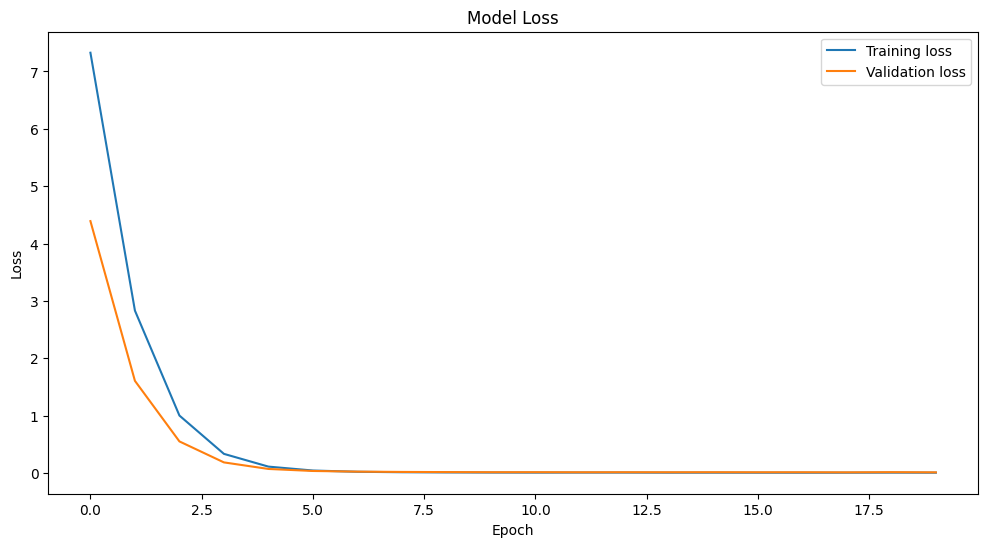

In [158]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [160]:
from sklearn.metrics import mean_squared_error

# Predictions
train_yhat = model.predict(X_train)
valid_yhat = model.predict(X_valid)
test_yhat = model.predict(X_test)

# Inverse transform the predictions and actual values
actual_train = bps_scaler.inverse_transform(y_train)
actual_valid = bps_scaler.inverse_transform(y_valid)
actual_test = bps_scaler.inverse_transform(y_test)

predicted_train = bps_scaler.inverse_transform(train_yhat)
predicted_valid = bps_scaler.inverse_transform(valid_yhat)
predicted_test = bps_scaler.inverse_transform(test_yhat)

def evaluate_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return rmse

train_rmse = evaluate_model(actual_train, predicted_train)
valid_rmse = evaluate_model(actual_valid, predicted_valid)
test_rmse = evaluate_model(actual_test, predicted_test)

print(f'Training RMSE: {train_rmse}')
print(f'Validation RMSE: {valid_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 18086308.411482822
Validation RMSE: 25296453.933143884
Test RMSE: 20966577.441127602


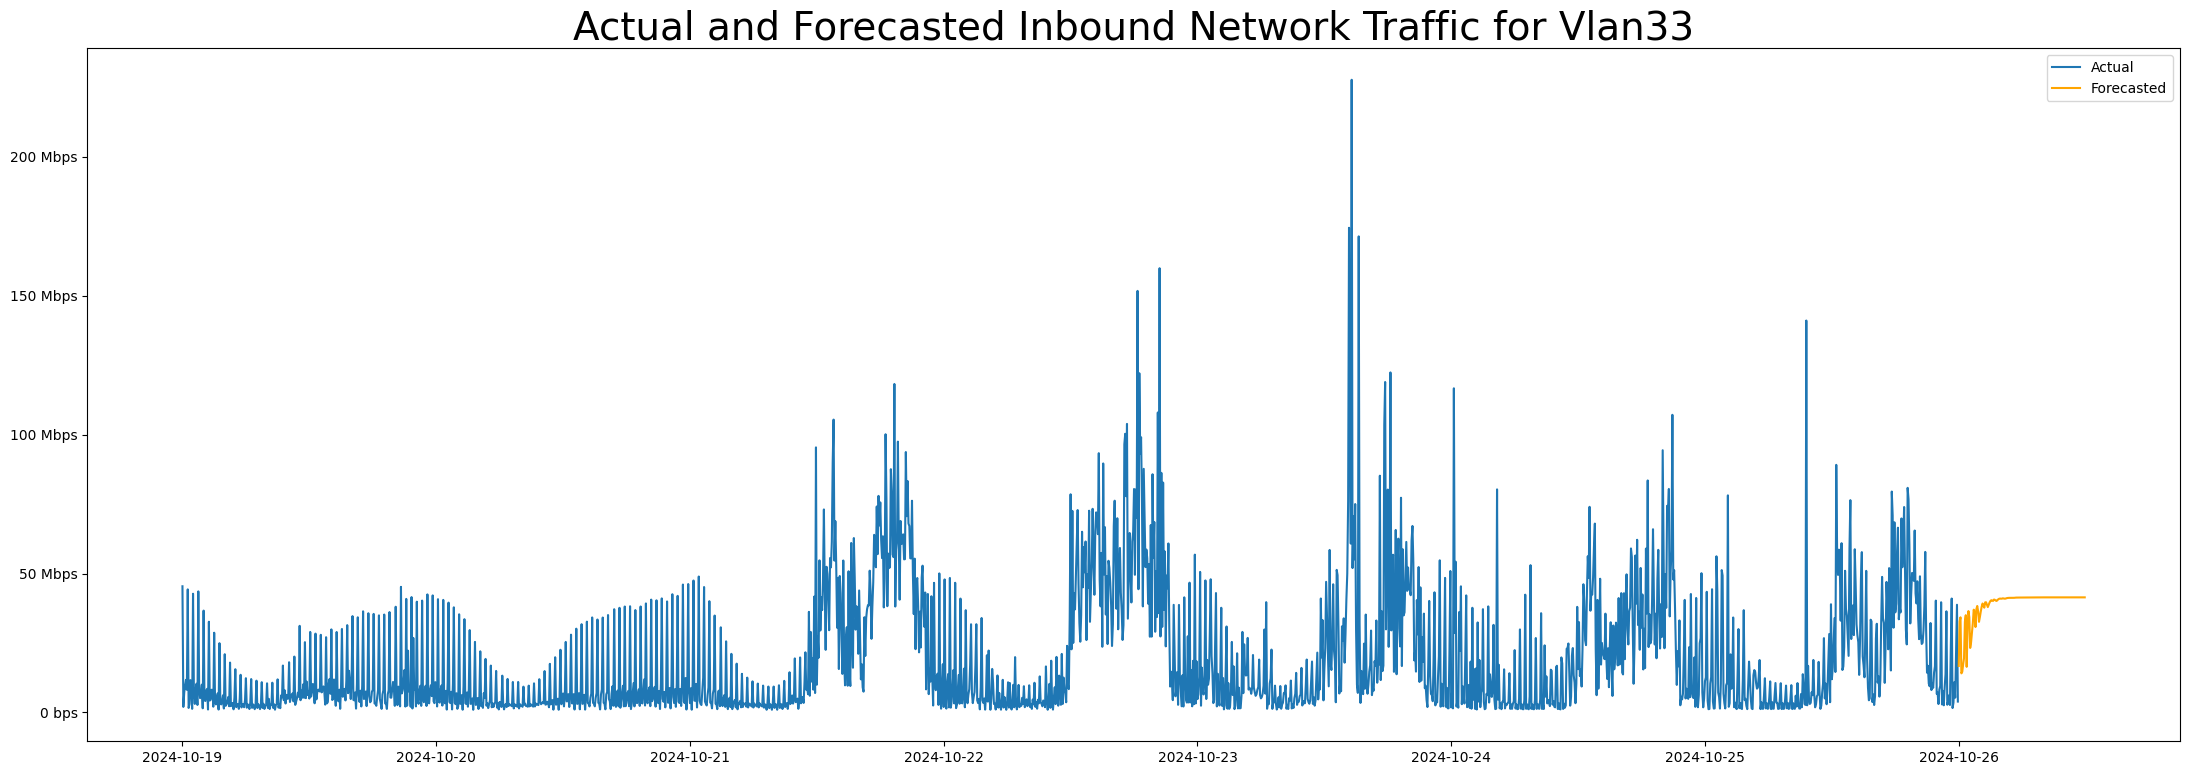

In [161]:
future_steps = 144

# Initialize the input sequence with the last observed data
input_seq = bps_scaled[-seq_length:].reshape(1, seq_length, 1)

future_predictions_scaled = []

for _ in range(future_steps):
    yhat = model.predict(input_seq, verbose=0)
    future_predictions_scaled.append(yhat[0, 0])

    # Update the input sequence
    input_seq = np.roll(input_seq, -1, axis=1)
    input_seq[0, -1, 0] = yhat[0, 0]

future_predictions = bps_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

last_date = df['date'].iloc[-1]
future_dates = [last_date + datetime.timedelta(minutes=5 * i) for i in range(1, future_steps + 1)]

df_future = pd.DataFrame({
    'date': future_dates,
    'predicted': future_predictions.flatten()
})

# Combine historical data and future predictions
df_combined = pd.DataFrame({
    'date': pd.concat([df['date'], df_future['date']]),
    'bps': pd.concat([df['bps'], pd.Series([np.nan]*len(df_future))]),
    'predicted': pd.concat([pd.Series([np.nan]*len(df)), df_future['predicted']])
})

# Plot the results
fig = plt.figure(figsize=(27, 9))
plt.title("Actual and Forecasted Inbound Network Traffic for Vlan33", fontdict={'fontsize': 28})

plt.plot(df_combined['date'], df_combined['bps'], label='Actual')
plt.plot(df_combined['date'], df_combined['predicted'], label='Forecasted', color='orange')

formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()

# Testing LSTM with pytorch library

814
402
torch.Size([811, 3, 1]) torch.Size([811, 3, 1])


/tmp/ipykernel_1219/1168261246.py:73: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipykernel_1219/1168261246.py:75: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 21714006.0000, test RMSE 34640468.0000


/tmp/ipykernel_1219/1168261246.py:83: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1, :]
/tmp/ipykernel_1219/1168261246.py:86: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


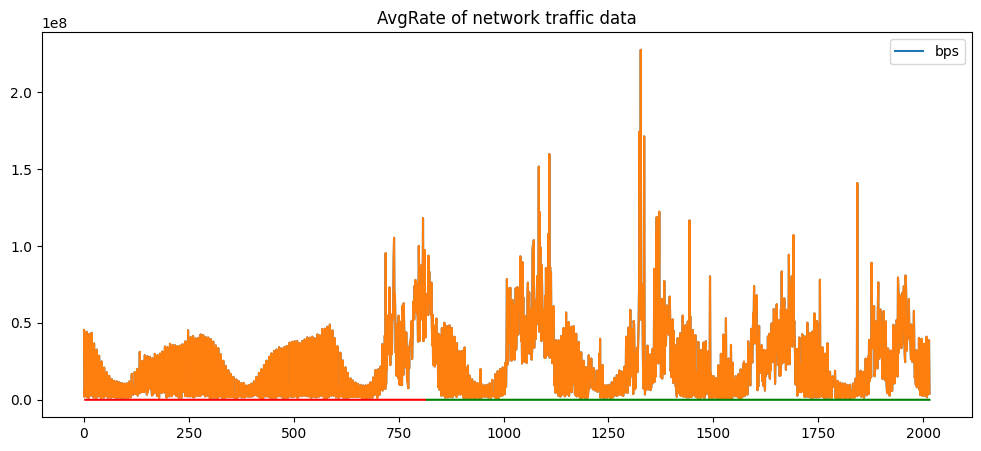

In [241]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

timeseries = df[["bps"]].values.astype('float32')

ax=df.plot(y='bps',figsize=(12,5), title="AvgRate of network traffic data")

# train-test split for time series
train_size = int((len(timeseries)-800)*0.67)
print(train_size)
test_size = len(timeseries)-800-train_size
print(test_size)

train, test = timeseries[:train_size], timeseries[train_size:]

import torch
import numpy as np


def create_dataset2(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))


lookback = 3
X_train, y_train = create_dataset2(train, lookback=lookback)
X_test, y_test = create_dataset2(test, lookback=lookback)
print(X_train.shape, y_train.shape)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')

In [242]:
from sklearn.metrics import mean_squared_error

# Predictions
train_yhat = model(X_train)
test_yhat = model(X_test)

# Inverse transform the predictions and actual values
actual_train = y_train
actual_test = y_test

predicted_train = train_yhat
predicted_test = test_yhat

def evaluate_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return rmse


actual_train = actual_train.detach().numpy().reshape(-1, 1)
actual_test = actual_test.detach().numpy().reshape(-1, 1)
predicted_train = predicted_train.detach().numpy().reshape(-1, 1)
predicted_test = predicted_test.detach().numpy().reshape(-1, 1)

train_rmse = evaluate_model(actual_train, predicted_train)
test_rmse = evaluate_model(actual_test, predicted_test)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 21713948.0
Test RMSE: 34640404.0


Train size: 1612
Test size: 404
X_train shape: torch.Size([1609, 3]), y_train shape: torch.Size([1609, 3])
X_test shape: torch.Size([401, 3]), y_test shape: torch.Size([401, 3])
Using device: cuda
Epoch 100/500, Train RMSE: 0.0734, Test RMSE: 0.0835
Epoch 200/500, Train RMSE: 0.0674, Test RMSE: 0.0870
Epoch 300/500, Train RMSE: 0.0662, Test RMSE: 0.0894
Epoch 400/500, Train RMSE: 0.0642, Test RMSE: 0.0893
Epoch 500/500, Train RMSE: 0.0708, Test RMSE: 0.0955


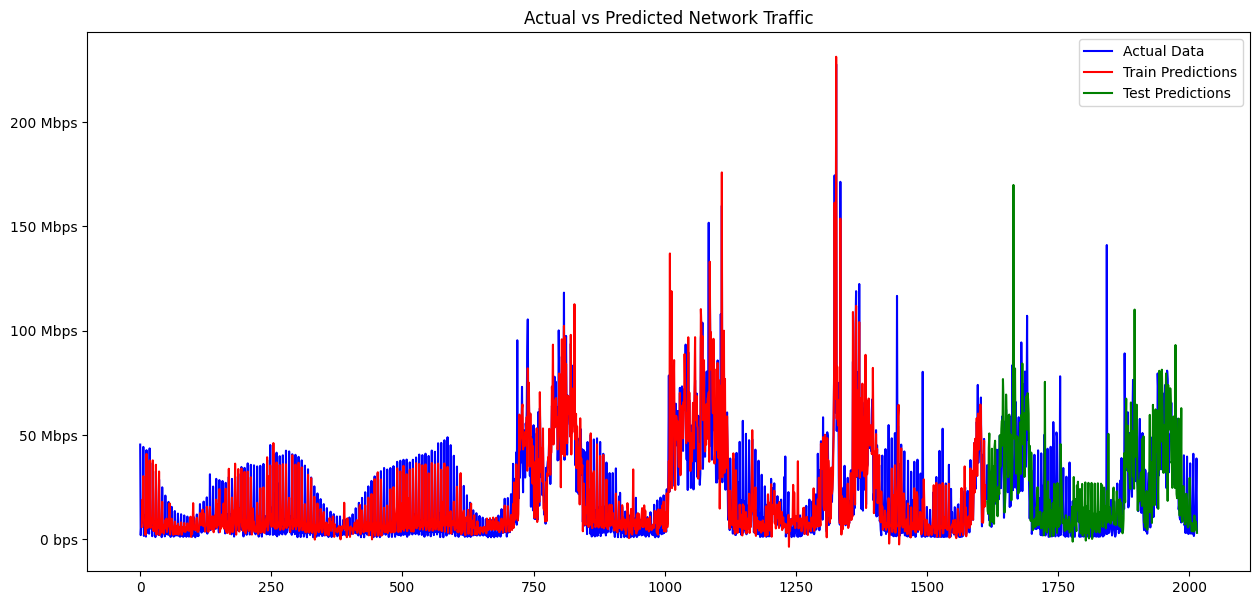

Final Training RMSE: 10738859.0000 bps
Final Test RMSE: 23146942.0000 bps


In [246]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# ============================
# 1. Data Preparation
# ============================

# Assume 'df' is your DataFrame containing the 'bps' column
# Replace this with your actual DataFrame loading if necessary
# Example:
# import pandas as pd
# df = pd.read_csv('your_data.csv')

# Extract the 'bps' column and convert it to a float32 numpy array
timeseries = df[["bps"]].values.astype('float32').flatten()

# Initialize the scaler
bps_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the entire dataset and transform
# Alternatively, you can fit only on the training data to prevent data leakage
timeseries_scaled = bps_scaler.fit_transform(timeseries.reshape(-1, 1)).flatten()

# ============================
# 2. Train-Test Split
# ============================

lookback = 3          # Number of previous timesteps to consider
forecast_offset = 800  # Offset to exclude recent data from training

train_size = int(len(timeseries_scaled) * 0.8)
test_size = len(timeseries_scaled) - train_size

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

# Split the scaled timeseries data into train and test sets
train_data = timeseries_scaled[:train_size]
test_data = timeseries_scaled[train_size:]

# ============================
# 3. Dataset Creation
# ============================

def create_dataset(dataset, lookback):
    """
    Transforms a time series into a supervised learning dataset suitable for LSTM models.

    Args:
        dataset (numpy.array): The time series data.
        lookback (int): Number of previous timesteps to use as input features.

    Returns:
        tuple: Tensors of input sequences and target sequences.
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:i + lookback])
        y.append(dataset[i + 1:i + lookback + 1])
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create datasets
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# ============================
# 4. Model Definition
# ============================

class TrafficLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=150, num_layers=5):
        super(TrafficLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out)
        return output

# ============================
# 5. Device Configuration
# ============================

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 6. Model Initialization
# ============================

# Initialize the model, loss function, and optimizer
model = TrafficLSTM().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# ============================
# 7. Prepare Data for Model
# ============================

# Reshape data to add the feature dimension and move to device
# LSTM expects input shape: (batch_size, seq_length, input_size)
X_train = X_train.unsqueeze(-1).to(device)
y_train = y_train.unsqueeze(-1).to(device)
X_test = X_test.unsqueeze(-1).to(device)
y_test = y_test.unsqueeze(-1).to(device)

# Create data loader for batching
train_dataset = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

# ============================
# 8. Training Loop
# ============================

n_epochs = 500
print_every = 100  # Frequency of printing training progress

for epoch in range(1, n_epochs + 1):
    model.train()
    for X_batch, y_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(X_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    # Validation every 'print_every' epochs
    if epoch % print_every == 0:
        model.eval()
        with torch.no_grad():
            # Training RMSE
            y_train_pred = model(X_train)
            train_loss = loss_fn(y_train_pred, y_train)
            train_rmse = torch.sqrt(train_loss).item()
            # Testing RMSE
            y_test_pred = model(X_test)
            test_loss = loss_fn(y_test_pred, y_test)
            test_rmse = torch.sqrt(test_loss).item()
        print(f"Epoch {epoch}/{n_epochs}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

# ============================
# 9. Inference and Inverse Scaling
# ============================

model.eval()
with torch.no_grad():
    # Get predictions
    y_train_pred = model(X_train).cpu().numpy()[:, -1, 0]
    y_test_pred = model(X_test).cpu().numpy()[:, -1, 0]

    # Inverse transform the scaled predictions
    y_train_pred_inverse = bps_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
    y_test_pred_inverse = bps_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    # Inverse transform the actual target values
    y_train_actual_inverse = bps_scaler.inverse_transform(y_train.cpu().numpy()[:, -1, 0].reshape(-1, 1)).flatten()
    y_test_actual_inverse = bps_scaler.inverse_transform(y_test.cpu().numpy()[:, -1, 0].reshape(-1, 1)).flatten()

    # Prepare arrays for plotting
    train_plot = np.full(len(timeseries), np.nan)
    test_plot = np.full(len(timeseries), np.nan)

    # Insert predictions into the correct positions
    train_plot[lookback:train_size] = y_train_pred_inverse
    test_plot[train_size + lookback:train_size + lookback + len(y_test_pred_inverse)] = y_test_pred_inverse

# ============================
# 10. Plotting Results
# ============================

plt.figure(figsize=(15, 7))
plt.plot(timeseries, label='Actual Data', color='blue')
plt.plot(train_plot, label='Train Predictions', color='red')
plt.plot(test_plot, label='Test Predictions', color='green')
plt.title("Actual vs Predicted Network Traffic")
formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

# ============================
# 11. Evaluation Metrics
# ============================

def evaluate_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return rmse

# Compute RMSE on the inverse-scaled data
train_rmse_final = evaluate_model(y_train_actual_inverse, y_train_pred_inverse)
test_rmse_final = evaluate_model(y_test_actual_inverse, y_test_pred_inverse)

print(f"Final Training RMSE: {train_rmse_final:.4f} bps")
print(f"Final Test RMSE: {test_rmse_final:.4f} bps")

[Timestamp('2024-10-26 00:00:00'), Timestamp('2024-10-26 00:05:00'), Timestamp('2024-10-26 00:10:00'), Timestamp('2024-10-26 00:15:00'), Timestamp('2024-10-26 00:20:00'), Timestamp('2024-10-26 00:25:00'), Timestamp('2024-10-26 00:30:00'), Timestamp('2024-10-26 00:35:00'), Timestamp('2024-10-26 00:40:00'), Timestamp('2024-10-26 00:45:00'), Timestamp('2024-10-26 00:50:00'), Timestamp('2024-10-26 00:55:00'), Timestamp('2024-10-26 01:00:00'), Timestamp('2024-10-26 01:05:00'), Timestamp('2024-10-26 01:10:00'), Timestamp('2024-10-26 01:15:00'), Timestamp('2024-10-26 01:20:00'), Timestamp('2024-10-26 01:25:00'), Timestamp('2024-10-26 01:30:00'), Timestamp('2024-10-26 01:35:00'), Timestamp('2024-10-26 01:40:00'), Timestamp('2024-10-26 01:45:00'), Timestamp('2024-10-26 01:50:00'), Timestamp('2024-10-26 01:55:00'), Timestamp('2024-10-26 02:00:00'), Timestamp('2024-10-26 02:05:00'), Timestamp('2024-10-26 02:10:00'), Timestamp('2024-10-26 02:15:00'), Timestamp('2024-10-26 02:20:00'), Timestamp('20

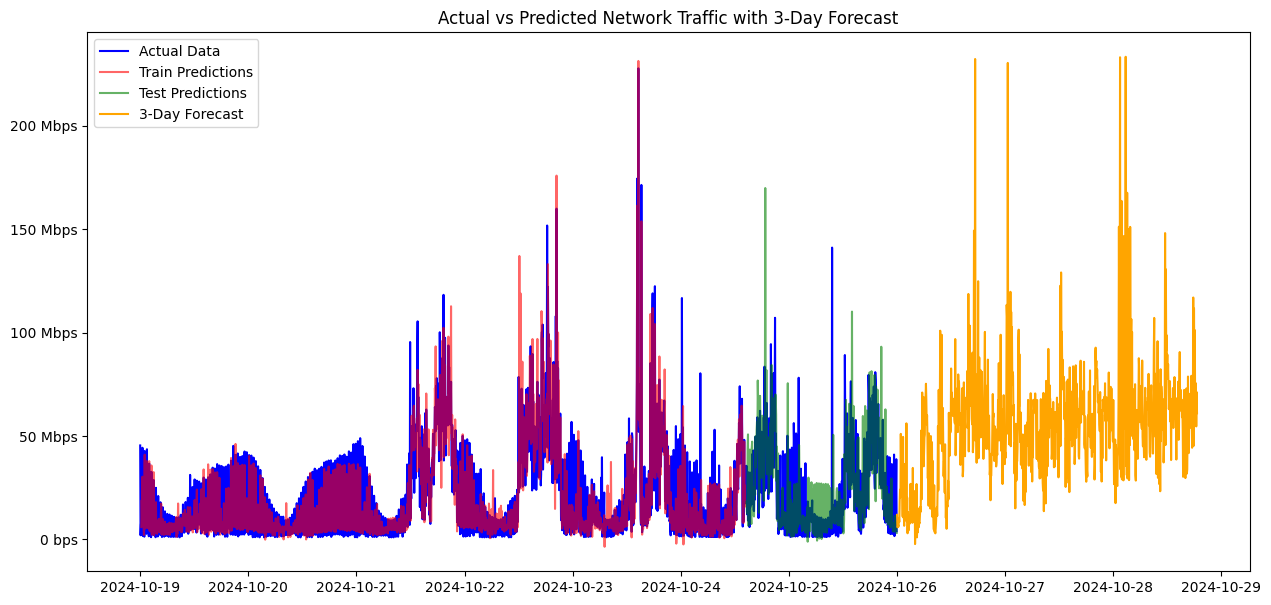

Final Training RMSE: 10738859.0000 bps
Final Test RMSE: 23146942.0000 bps

Forecasted Values:
                     forecasted_bps
timestamp                          
2024-10-26 00:00:00    1.187082e+07
2024-10-26 00:05:00    5.889596e+06
2024-10-26 00:10:00    5.959184e+06
2024-10-26 00:15:00    6.975979e+06
2024-10-26 00:20:00    6.211770e+06


In [247]:
# ============================
# 12. Forecasting 3 Days Forward
# ============================

# Start with the last 'lookback' steps from the test data
last_sequence = test_data[-lookback:].tolist()

last_timestamp = df['date'].iloc[-1]
forecast_timestamps = [last_timestamp + datetime.timedelta(minutes=5 * i) for i in range(1, forecast_steps + 1)]
forecast_steps = len(forecast_timestamps)

# List to store forecasted values
forecast_scaled = []

model.eval()
with torch.no_grad():
    for _ in range(forecast_steps):
        # Prepare the input sequence
        input_seq = torch.tensor(last_sequence[-lookback:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        # Get the model prediction
        pred = model(input_seq)
        # Extract the last prediction
        pred_value = pred[0, -1, 0].item()
        # Append the prediction to the forecast list
        forecast_scaled.append(pred_value)
        # Append the prediction to the last_sequence for the next prediction
        last_sequence.append(pred_value)

# Inverse transform the forecasted values
forecast_inverse = bps_scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# ============================
# 13. Plotting Results
# ============================

plt.figure(figsize=(15, 7))
plt.plot(df['date'], timeseries, label='Actual Data', color='blue')
plt.plot(df['date'], train_plot, label='Train Predictions', color='red', alpha=0.6)
plt.plot(df['date'], test_plot, label='Test Predictions', color='green', alpha=0.6)
plt.plot(forecast_timestamps, forecast_inverse, label='3-Day Forecast', color='orange')
plt.title("Actual vs Predicted Network Traffic with 3-Day Forecast")
formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

# ============================
# 14. Evaluation Metrics
# ============================

def evaluate_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return rmse

# Compute RMSE on the inverse-scaled data
train_rmse_final = evaluate_model(y_train_actual_inverse, y_train_pred_inverse)
test_rmse_final = evaluate_model(y_test_actual_inverse, y_test_pred_inverse)

print(f"Final Training RMSE: {train_rmse_final:.4f} bps")
print(f"Final Test RMSE: {test_rmse_final:.4f} bps")

# ============================
# 15. Save Forecasted Data (Optional)
# ============================

# Create a DataFrame for the forecasted data
forecast_df = pd.DataFrame({
    'timestamp': forecast_timestamps,
    'forecasted_bps': forecast_inverse
})
forecast_df.set_index('timestamp', inplace=True)

# Optionally, save the forecast to a CSV file
# forecast_df.to_csv('network_traffic_forecast.csv')

# Display the first few forecasted values
print("\nForecasted Values:")
print(forecast_df.head())

# Forecasting using Prophet algorithm

01:23:03 - cmdstanpy - INFO - Chain [1] start processing
01:23:03 - cmdstanpy - INFO - Chain [1] done processing


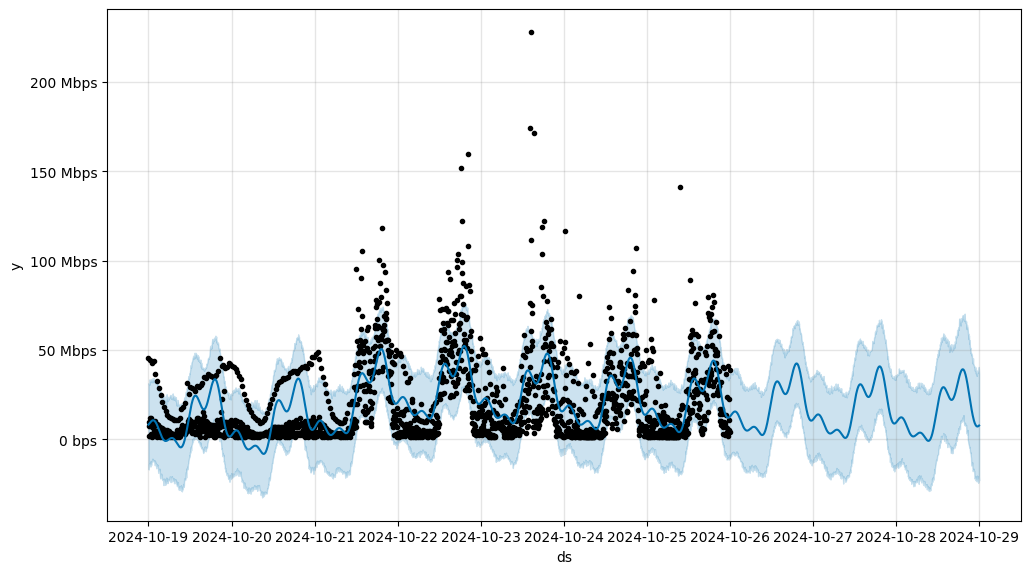

In [ ]:
from prophet import Prophet

# Prepare data
df_prophet = df[['date', 'bps']].rename(columns={'date': 'ds', 'bps': 'y'})

# Initialize and fit model
model = Prophet()
model.fit(df_prophet)

# Create future dataframe
future = model.make_future_dataframe(periods=288*3, freq='5min')

# Forecast
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)
formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

# Using ARIMA to forecast the network traffic

## Resample data with hour averages to make it more faster to fit

In [166]:
df_hourly = df.copy()
df_hourly['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M')
df_hourly.set_index('date')

df_hourly = df_hourly.groupby(pd.Grouper(key='date', freq='60min'))["bps"].mean().reset_index().fillna(0)[:-1]
print(df_hourly)

                   date           bps
0   2024-10-19 00:00:00  1.302485e+07
1   2024-10-19 01:00:00  1.245842e+07
2   2024-10-19 02:00:00  1.021505e+07
3   2024-10-19 03:00:00  7.619289e+06
4   2024-10-19 04:00:00  5.949305e+06
..                  ...           ...
162 2024-10-25 18:00:00  5.131487e+07
163 2024-10-25 19:00:00  5.023927e+07
164 2024-10-25 20:00:00  3.574071e+07
165 2024-10-25 21:00:00  1.571601e+07
166 2024-10-25 22:00:00  1.190378e+07

[167 rows x 2 columns]


## Augmented Dickey-Fuller, ACF and PACF test

In [167]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_hourly['bps'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.314769
p-value: 0.000005
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.577


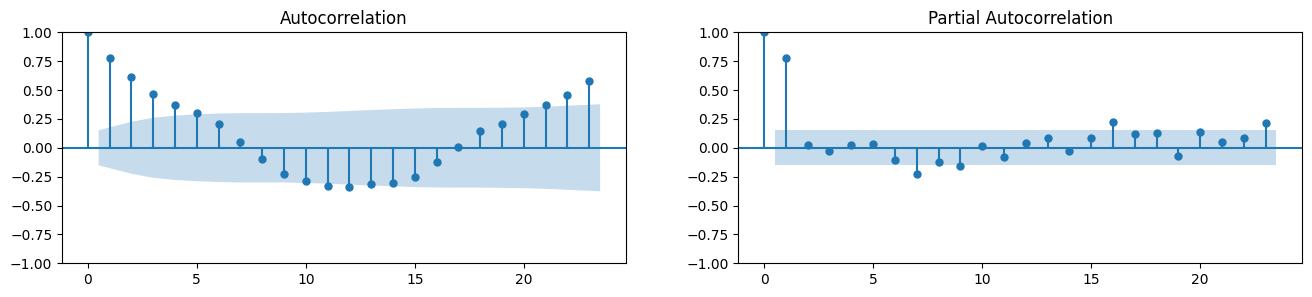

In [168]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(df_hourly['bps'], ax=axes[0])
plot_pacf(df_hourly['bps'], ax=axes[1])

plt.show()

## Training SARIMAX with selected order

In [169]:
import statsmodels.api as sm

# Define the SARIMA model
p, d, q = 5, 0, 2
P, D, Q, s = 5, 0, 2, 24  # Seasonal parameters

model = sm.tsa.statespace.SARIMAX(df_hourly['bps'], order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38620D+00    |proj g|=  1.34715D-01


 This problem is unconstrained.



At iterate    5    f=  4.35761D+00    |proj g|=  9.52790D-03

At iterate   10    f=  4.35431D+00    |proj g|=  4.43091D-03

At iterate   15    f=  4.35281D+00    |proj g|=  2.56009D-02

At iterate   20    f=  4.34994D+00    |proj g|=  8.80003D-03

At iterate   25    f=  4.34898D+00    |proj g|=  2.19886D-03

At iterate   30    f=  4.34814D+00    |proj g|=  6.06062D-03

At iterate   35    f=  4.34805D+00    |proj g|=  2.86644D-03

At iterate   40    f=  4.34802D+00    |proj g|=  1.75097D-03

At iterate   45    f=  4.34802D+00    |proj g|=  2.14674D-04


/root/test-uel/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.34802D+00    |proj g|=  6.80085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     56      1     0     0   6.801D-04   4.348D+00
  F =   4.3480153728626769     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                                bps   No. Observations:                  167
Model:             SARIMAX(5, 0, 2)x(5, 0, 2, 24)   Log Likelihood                -726.119
Date:                            Sun, 27 Oct 2024   AIC                           1482.2

## Forecasting future values with trained SARIMAX model

In [172]:
# Number of periods to forecast (3 days * 24 hours)
forecast_steps = 5 * 24

pred_uc = results.get_forecast(steps=forecast_steps)
pred_ci = pred_uc.conf_int()

# Get the forecasted mean values
forecasted_values = pred_uc.predicted_mean

last_date = df_hourly['date'].values[-1]
last_date = pd.to_datetime([last_date], format='%Y%m%d%H%M')[0]
future_dates = [last_date + datetime.timedelta(minutes=60 * i) for i in range(1, forecast_steps + 1)]
future_dates = pd.to_datetime(future_dates)

## Seeing the results of forecasts from SARIMAX

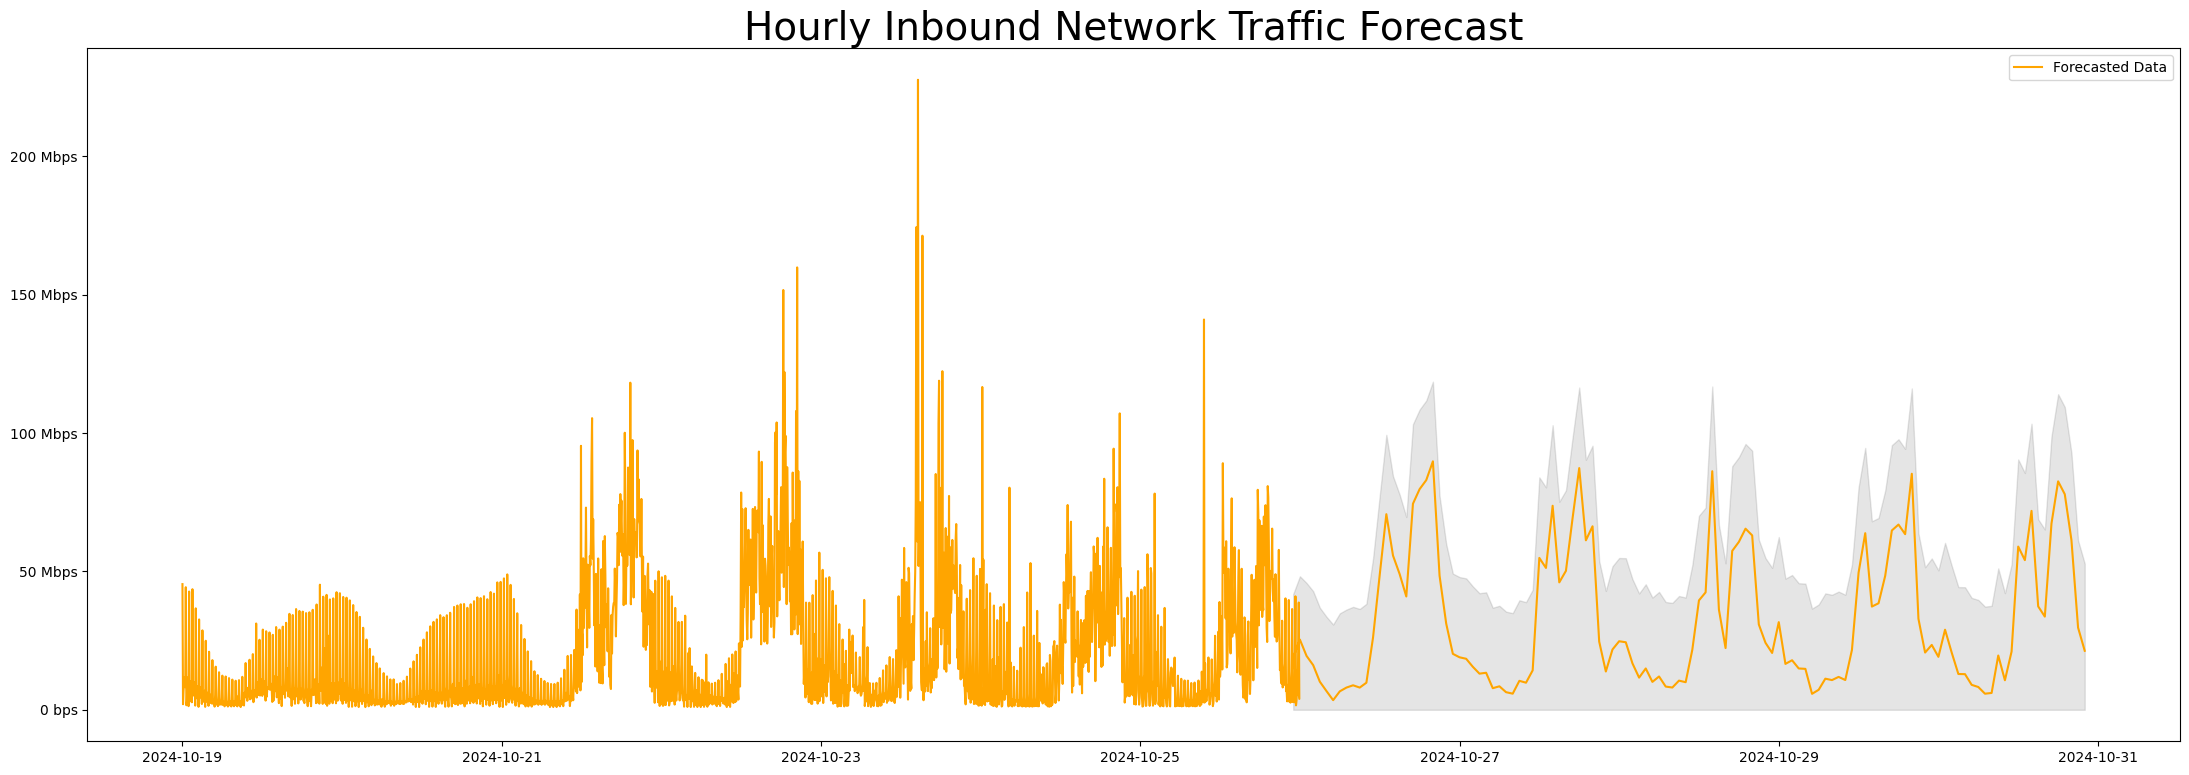

In [173]:
df_future = pd.DataFrame({
    'date': future_dates,
    'predicted': forecasted_values
})

# Combine historical actual data and future predictions
df_combined = pd.concat([
    df[['date', 'bps']].rename(columns={'bps': 'actual'}),
    df_future.rename(columns={'predicted': 'actual'})
], ignore_index=True)

plt.figure(figsize=(27, 9))
plt.plot(df_combined['date'], df_combined['actual'], label='Forecasted Data', color='orange')
plt.fill_between(future_dates, 0, pred_ci.iloc[:, 1], color='k', alpha=0.1)

plt.title('Hourly Inbound Network Traffic Forecast', fontdict={'fontsize': 28})
formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()

He don't recognize the traffic of weekend days, so maybe we need to add something like the day of week to fit the model.

In [200]:
# Create exogenous variables
df_hourly_exog = df_hourly.copy()
df_hourly_exog.set_index('date', inplace=True)
df_hourly_exog['hour'] = df_hourly_exog.index.hour
df_hourly_exog['day_of_week'] = df_hourly_exog.index.dayofweek

# One-hot encode categorical variables
exog = pd.get_dummies(df_hourly_exog[['hour', 'day_of_week']], columns=['hour', 'day_of_week'])

# Split data into training and forecasting sets
exog_train = exog.iloc[:-forecast_steps]
exog_forecast = exog.iloc[-forecast_steps:]

# Define the SARIMA model
p, d, q = 3, 0, 1
P, D, Q, s = 2, 0, 2, 24  # Seasonal parameters

# Fit SARIMAX model with exogenous variables
model_exog = sm.tsa.statespace.SARIMAX(df_hourly_exog['bps'][:-forecast_steps], exog=exog_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results_exog = model_exog.fit()
print(results_exog.summary())

/root/test-uel/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/root/test-uel/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/root/test-uel/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           40     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47164D+01    |proj g|=  4.65255D-01

At iterate    5    f=  1.45480D+01    |proj g|=  9.28957D-03

At iterate   10    f=  1.45457D+01    |proj g|=  3.19785D-02

At iterate   15    f=  1.45395D+01    |proj g|=  3.08233D-03

At iterate   20    f=  1.45395D+01    |proj g|=  2.14769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   40     22     24      1     0     0   7.011D-06   1.454D+01
  F =   14.539475663393363     

CONVERG

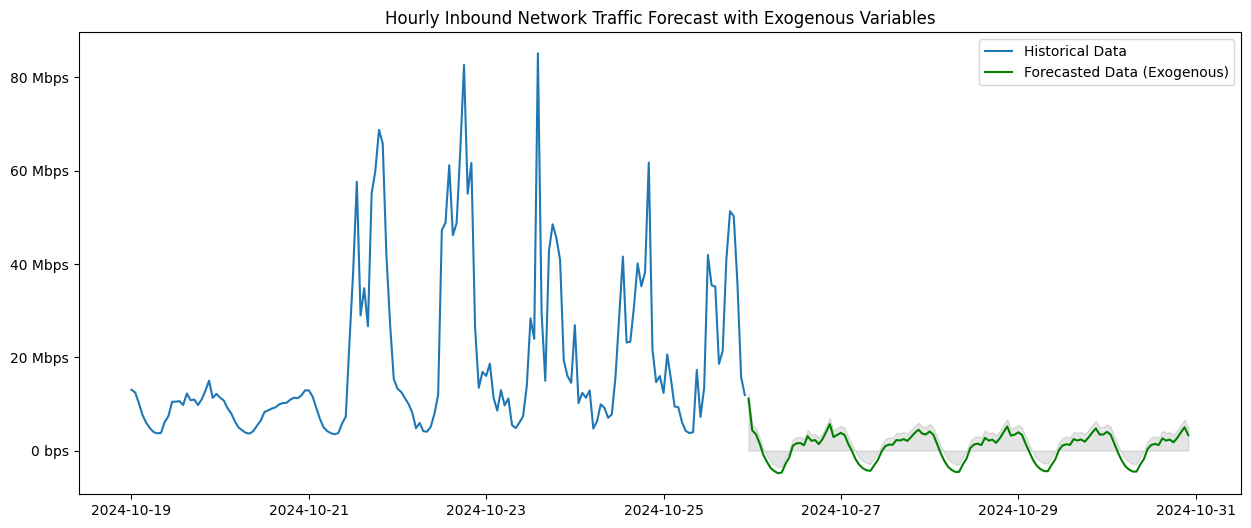

In [201]:
# Forecast with exogenous variables
pred_uc_exog = results_exog.get_forecast(steps=forecast_steps, exog=exog_forecast)
pred_ci_exog = pred_uc_exog.conf_int()
forecasted_values_exog = pred_uc_exog.predicted_mean

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(df_hourly_exog.index, df_hourly_exog['bps'], label='Historical Data')
plt.plot(future_dates, forecasted_values_exog, label='Forecasted Data (Exogenous)', color='green')
plt.fill_between(future_dates, 0, pred_ci_exog.iloc[:, 1], color='k', alpha=0.1)
plt.title('Hourly Inbound Network Traffic Forecast with Exogenous Variables')
formatter = EngFormatter(unit='bps')
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()